In [105]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
train_CSV = "/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv"
df = pd.read_csv(train_CSV)

In [108]:
train_image = "/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Training/training_words"

# **Exploratory Data Analysis(EDA)**

In [109]:
print(df.head)

<bound method NDFrame.head of          IMAGE MEDICINE_NAME            GENERIC_NAME
0        0.png         Aceta             Paracetamol
1        1.png         Aceta             Paracetamol
2        2.png         Aceta             Paracetamol
3        3.png         Aceta             Paracetamol
4        4.png         Aceta             Paracetamol
...        ...           ...                     ...
3115  3115.png       Zithrin  Azithromycin Dihydrate
3116  3116.png       Zithrin  Azithromycin Dihydrate
3117  3117.png       Zithrin  Azithromycin Dihydrate
3118  3118.png       Zithrin  Azithromycin Dihydrate
3119  3119.png       Zithrin  Azithromycin Dihydrate

[3120 rows x 3 columns]>


In [110]:
print(df["MEDICINE_NAME"].unique())

['Aceta' 'Ace' 'Alatrol' 'Amodis' 'Atrizin' 'Axodin' 'Azithrocin' 'Azyth'
 'Az' 'Bacaid' 'Backtone' 'Baclofen' 'Baclon' 'Bacmax' 'Beklo' 'Bicozin'
 'Canazole' 'Candinil' 'Cetisoft' 'Conaz' 'Dancel' 'Denixil' 'Diflu'
 'Dinafex' 'Disopan' 'Esonix' 'Esoral' 'Etizin' 'Exium' 'Fenadin'
 'Fexofast' 'Fexo' 'Filmet' 'Fixal' 'Flamyd' 'Flexibac' 'Flexilax'
 'Flugal' 'Ketocon' 'Ketoral' 'Ketotab' 'Ketozol' 'Leptic' 'Lucan-R'
 'Lumona' 'M-Kast' 'Maxima' 'Maxpro' 'Metro' 'Metsina' 'Monas' 'Montair'
 'Montene' 'Montex' 'Napa Extend' 'Napa' 'Nexcap' 'Nexum' 'Nidazyl'
 'Nizoder' 'Odmon' 'Omastin' 'Opton' 'Progut' 'Provair' 'Renova' 'Rhinil'
 'Ritch' 'Rivotril' 'Romycin' 'Rozith' 'Sergel' 'Tamen' 'Telfast'
 'Tridosil' 'Trilock' 'Vifas' 'Zithrin']


<ipython-input-111-131c6ad874ed>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


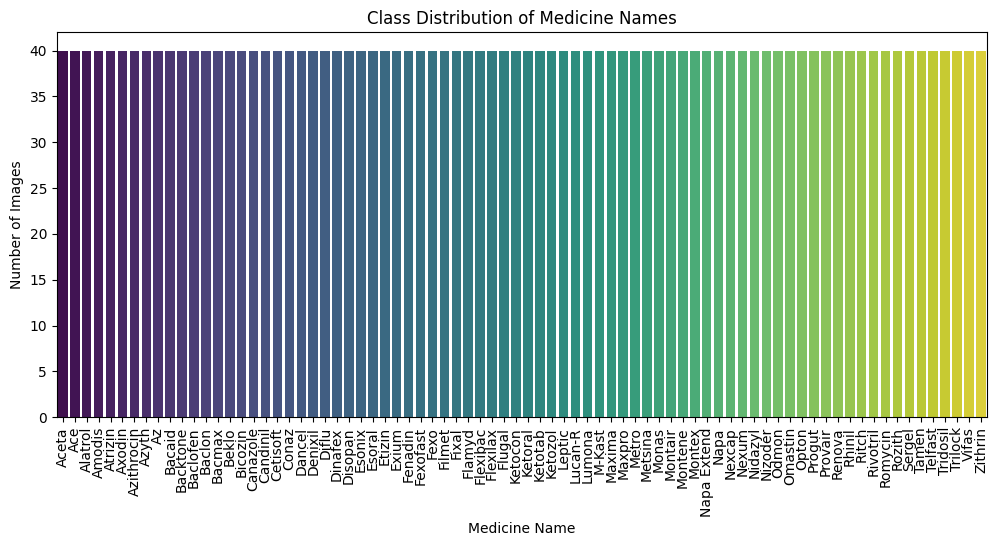

In [111]:
class_counts = df["MEDICINE_NAME"].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Class Distribution of Medicine Names")
plt.xlabel("Medicine Name")
plt.ylabel("Number of Images")
plt.show()

In [112]:
# img=cv2.imread("/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words/0.png")

In [113]:
# img.shape

In [114]:
# img1=cv2.imread("/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words/1.png")

In [115]:
# img1.shape

In [116]:
def show_sample_images(df, train_image, num_samples=5):
    sample_data = df.sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, (idx, row) in enumerate(sample_data.iterrows()):
        img_path = os.path.join(train_image, row["IMAGE"])

        # Check if the image exists
        if not os.path.exists(img_path):
            print(f" Image not found: {img_path}")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f" Failed to load: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].set_title(row["MEDICINE_NAME"])
        axes[i].axis("off")

    plt.show()




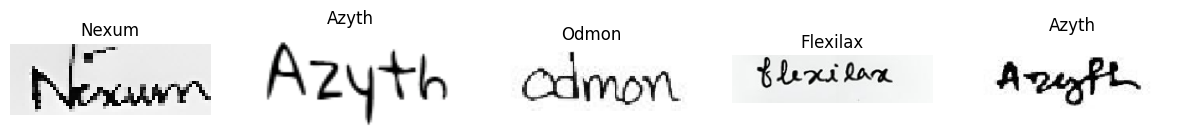

In [117]:
show_sample_images(df, train_image)

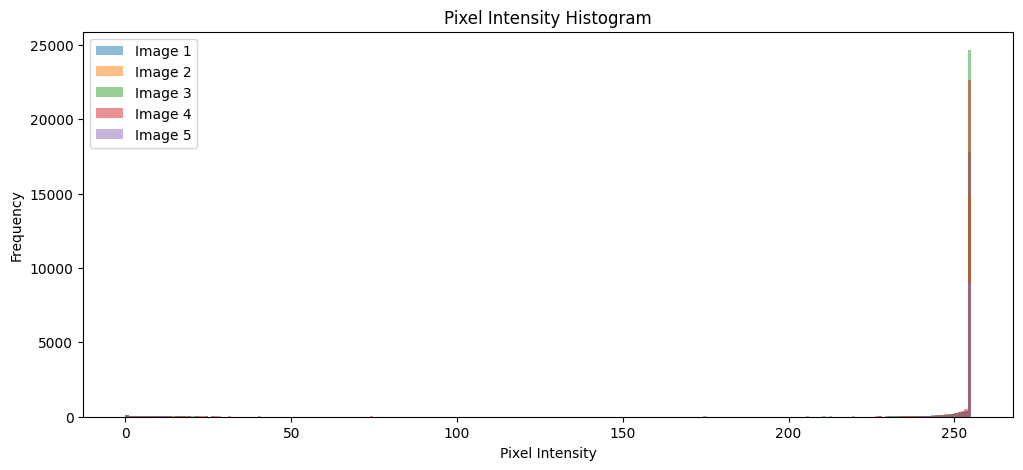

In [118]:
def plot_pixel_intensity(df, train_image, num_samples=5):
    plt.figure(figsize=(12, 5))

    for i in range(num_samples):
        img_path = os.path.join(train_image, df.iloc[i]["IMAGE"])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            plt.hist(img.ravel(), bins=256, alpha=0.5, label=f"Image {i+1}")

    plt.legend()
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

plot_pixel_intensity(df, train_image)

# **PRE-PROCESSING**

In [119]:
train_output_folder = "/content/train_preprocessed_images"
os.makedirs(train_output_folder, exist_ok=True)

In [120]:
validation_output_folder = "/content/valdiation_preprocessed_images"
os.makedirs(validation_output_folder, exist_ok=True)

In [121]:
test_output_folder = "/content/test_preprocessed_images"
os.makedirs(test_output_folder, exist_ok=True)

In [122]:
def show_image(title, img):
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [123]:
def preprocess_and_save_images(input_folder,output_folder, target_size=(128, 128)):
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(input_folder, image_file)
        img = cv2.imread(image_path)

        if img is None:
            print(f"Error loading image: {image_file}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        resized = cv2.resize(gray, target_size)

        _, binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        save_path = os.path.join(output_folder, image_file)
        cv2.imwrite(save_path, binary)

        if i < 5:
            show_image(f"Processed: {image_file}", binary)

    print(f"Processed {len(image_files)} images and saved to {output_folder}")

In [124]:
train_input_folder = "/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Training/training_words"

In [125]:
validation_input_folder = "/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words"

In [126]:
test_input_folder = "/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words"

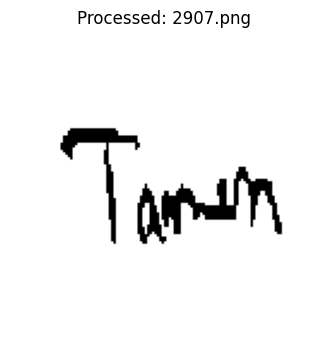

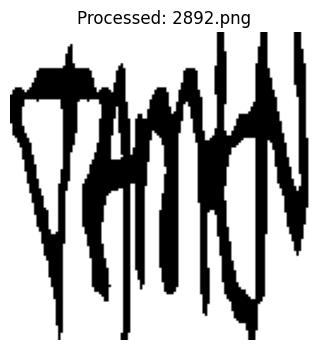

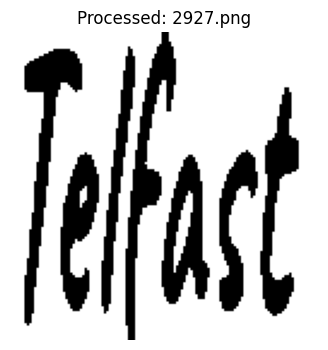

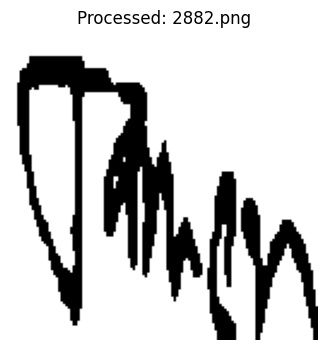

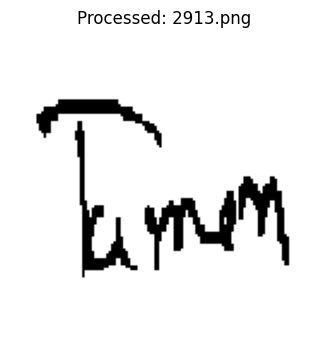

Processed 3120 images and saved to /content/train_preprocessed_images


In [127]:
preprocess_and_save_images(train_input_folder,train_output_folder)

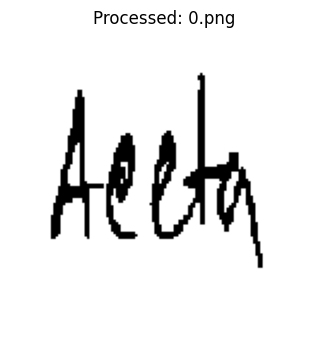

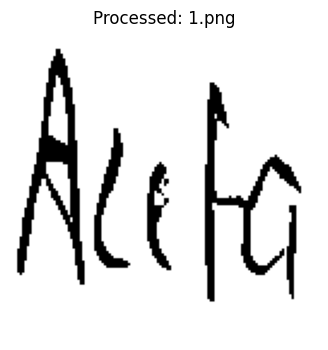

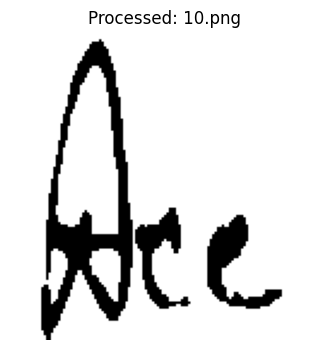

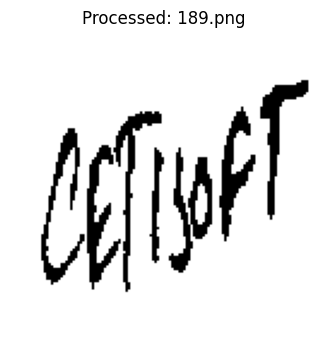

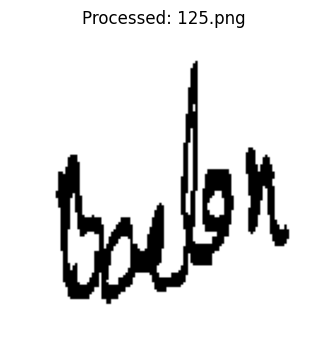

Processed 780 images and saved to /content/valdiation_preprocessed_images


In [128]:
preprocess_and_save_images(validation_input_folder,validation_output_folder)

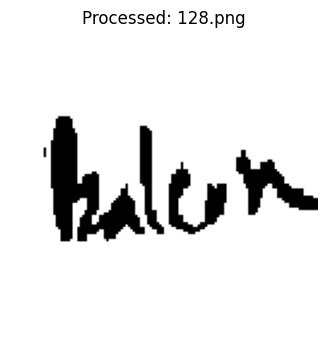

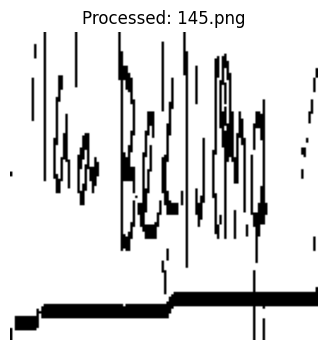

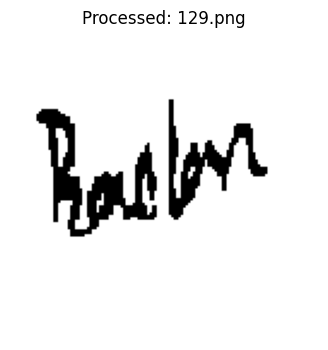

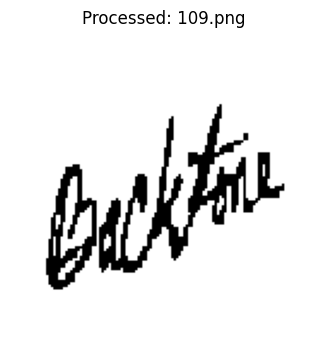

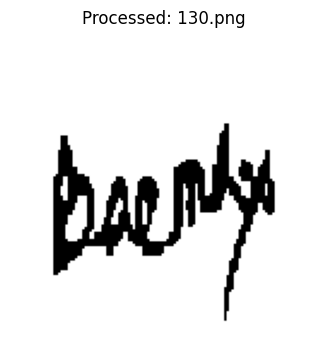

Processed 800 images and saved to /content/test_preprocessed_images


In [129]:
preprocess_and_save_images(test_input_folder,test_output_folder)

# **Feature Extraction**

In [130]:
import pandas as pd
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [131]:
# Define base directory where images and CSV files are stored
base_dir = "/content"  # Change this path if needed

# Image folders
train_img_dir = os.path.join(base_dir, "train_preprocessed_images")
val_img_dir = os.path.join(base_dir, "valdiation_preprocessed_images")
test_img_dir = os.path.join(base_dir, "test_preprocessed_images")



In [132]:
# CSV files containing image names and labels
train_csv =("/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv")
val_csv = ("/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv")
test_csv = ("/content/drive/MyDrive/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv")


In [133]:
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

In [134]:
print("Train CSV Sample:\n", train_df.head())

Train CSV Sample:
    IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol


In [135]:
print("Validation CSV Sample:\n", val_df.head())

Validation CSV Sample:
    IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol


In [136]:
print("Test CSV Sample:\n", test_df.head())

Test CSV Sample:
    IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol


In [137]:
# Function to get full image path
def get_image_path(image_name, folder):
    return os.path.join(folder, image_name)

# Add image paths to DataFrames
train_df["image_path"] = train_df["IMAGE"].apply(lambda x: get_image_path(x, train_img_dir))
val_df["image_path"] = val_df["IMAGE"].apply(lambda x: get_image_path(x, val_img_dir))
test_df["image_path"] = test_df["IMAGE"].apply(lambda x: get_image_path(x, test_img_dir))

In [138]:
print(train_df.head())

   IMAGE MEDICINE_NAME GENERIC_NAME                                image_path
0  0.png         Aceta  Paracetamol  /content/train_preprocessed_images/0.png
1  1.png         Aceta  Paracetamol  /content/train_preprocessed_images/1.png
2  2.png         Aceta  Paracetamol  /content/train_preprocessed_images/2.png
3  3.png         Aceta  Paracetamol  /content/train_preprocessed_images/3.png
4  4.png         Aceta  Paracetamol  /content/train_preprocessed_images/4.png


In [139]:
# Label encoding
label_encoder = LabelEncoder()

In [140]:
# Fit on training labels and transform labels into numeric values
train_df["label"] = label_encoder.fit_transform(train_df["MEDICINE_NAME"])
val_df["label"] = label_encoder.transform(val_df["MEDICINE_NAME"])
test_df["label"] = label_encoder.transform(test_df["MEDICINE_NAME"])

In [141]:
# Print class mappings
print("Class Mappings:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Class Mappings: {'Ace': 0, 'Aceta': 1, 'Alatrol': 2, 'Amodis': 3, 'Atrizin': 4, 'Axodin': 5, 'Az': 6, 'Azithrocin': 7, 'Azyth': 8, 'Bacaid': 9, 'Backtone': 10, 'Baclofen': 11, 'Baclon': 12, 'Bacmax': 13, 'Beklo': 14, 'Bicozin': 15, 'Canazole': 16, 'Candinil': 17, 'Cetisoft': 18, 'Conaz': 19, 'Dancel': 20, 'Denixil': 21, 'Diflu': 22, 'Dinafex': 23, 'Disopan': 24, 'Esonix': 25, 'Esoral': 26, 'Etizin': 27, 'Exium': 28, 'Fenadin': 29, 'Fexo': 30, 'Fexofast': 31, 'Filmet': 32, 'Fixal': 33, 'Flamyd': 34, 'Flexibac': 35, 'Flexilax': 36, 'Flugal': 37, 'Ketocon': 38, 'Ketoral': 39, 'Ketotab': 40, 'Ketozol': 41, 'Leptic': 42, 'Lucan-R': 43, 'Lumona': 44, 'M-Kast': 45, 'Maxima': 46, 'Maxpro': 47, 'Metro': 48, 'Metsina': 49, 'Monas': 50, 'Montair': 51, 'Montene': 52, 'Montex': 53, 'Napa': 54, 'Napa Extend': 55, 'Nexcap': 56, 'Nexum': 57, 'Nidazyl': 58, 'Nizoder': 59, 'Odmon': 60, 'Omastin': 61, 'Opton': 62, 'Progut': 63, 'Provair': 64, 'Renova': 65, 'Rhinil': 66, 'Ritch': 67, 'Rivotril': 68, 'Romy

In [142]:
# Image size
IMG_SIZE = (64, 64) # 128,128

# Function to load images
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if image is None:
        print(f"Error loading image: {image_path}")
        return np.zeros((IMG_SIZE[0], IMG_SIZE[1]))  # Return blank image if error
    image = image / 255.0  # Normalize to [0,1]
    return image

In [143]:
# Load train images
train_images = np.array([load_image(img) for img in train_df["image_path"]]).reshape(-1, 128, 128, 1)
train_labels = np.array(train_df["label"])

In [144]:
# Load validation images
val_images = np.array([load_image(img) for img in val_df["image_path"]]).reshape(-1, 128, 128, 1)
val_labels = np.array(val_df["label"])

In [145]:
# Load test images
test_images = np.array([load_image(img) for img in test_df["image_path"]]).reshape(-1, 128, 128, 1)
test_labels = np.array(test_df["label"])

In [146]:
# Convert labels to categorical (one-hot encoding)
train_labels = to_categorical(train_labels, num_classes=len(label_encoder.classes_))
val_labels = to_categorical(val_labels, num_classes=len(label_encoder.classes_))
test_labels = to_categorical(test_labels, num_classes=len(label_encoder.classes_))

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU

# Create CNN model
model = Sequential([
    Conv2D(32, (3,3), input_shape=(128, 128, 1)),  # Grayscale input
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation="softmax")  # Output layer
])

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 78)             │        10,062 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,314,126 (12.64 MB)

 Trainable params: 3,314,126 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [149]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=25,       # Rotate images up to 15 degrees
    width_shift_range=0.1,   # Shift width by 10%
    height_shift_range=0.1,  # Shift height by 10%
    zoom_range=0.1,          # Zoom images up to 10%
    horizontal_flip=True,    # Flip images horizontally
)

# Fit the generator to training data
datagen.fit(train_images)



In [150]:
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),  # Use augmented data
    validation_data=(val_images, val_labels),
    epochs=50,  # Increase epochs after adding augmentation
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.0166 - loss: 4.3572 - val_accuracy: 0.0603 - val_loss: 4.0499
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0412 - loss: 4.1489 - val_accuracy: 0.1167 - val_loss: 3.8264
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.0773 - loss: 3.9826 - val_accuracy: 0.1231 - val_loss: 3.7213
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1280 - loss: 3.6923 - val_accuracy: 0.1526 - val_loss: 3.5481
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.1685 - loss: 3.4154 - val_accuracy: 0.2974 - val_loss: 2.9422
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2164 - loss: 3.2130 - val_accuracy: 0.3038 - val_loss: 2.8687
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2481 - loss: 3.0166 - val_accuracy: 0.3897 - val_loss: 2.5100
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.2797 - loss: 2.8213 - val_accuracy: 0.4769 - val_loss: 

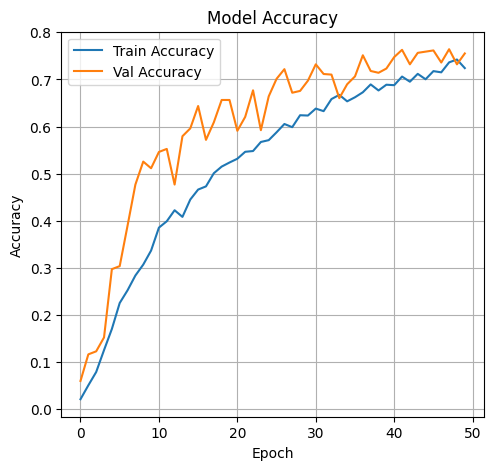

In [151]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

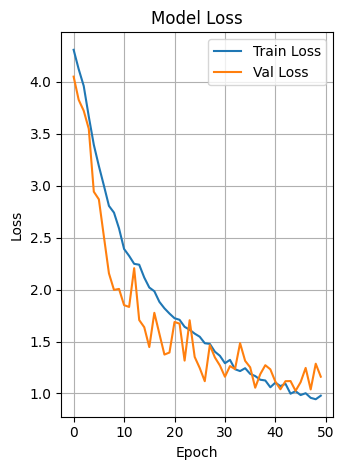

In [152]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [153]:
# model.save("/kaggle/working/cnn_model.h5")

In [157]:
_, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7021 - loss: 1.6551
Test Accuracy: 0.7021


In [155]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [156]:
print("Predicted:", predicted_labels[:10])
print("Actual:", true_labels[:10])

Predicted: [ 1 40  1  1  1 14  1  1  1  9]
Actual: [1 1 1 1 1 1 1 1 1 1]
